In [1]:
from tqdm import tqdm
import shutil
from pathlib import Path
import os
import sys

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

In [2]:
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import json

from utils import *
from IQA_metrics import *
from data_analysis import EmbeddingDataset
from siamese import generate_train_test_set
from imblearn.over_sampling import SMOTE

plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["axes.linewidth"] = 0.8
plt.rcParams["legend.handlelength"] = 2.0
minor_locator = AutoMinorLocator(4)

In [3]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data/multi_classed_grouped_data")
products = os.listdir(data_path)

In [4]:
# Find optimal embedding through the embeddings of good samples
generate_embeddings_dict = False
find_embeddings = True


# ResNet50 model to find embeddings
model = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")
# model.fc = nn.Linear(2048, 2)
modules = list(model.children())[:-1]
model = nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Find model image by embedding for each product
if generate_embeddings_dict:
    for product in products:
        print("----------------------------" +
              product + "----------------------------")
        product_path = os.path.join(data_path, product)
        good_images_path = os.path.join(product_path, "train")
        defect_images_path = os.path.join(product_path, "test/defect")

        (
            train_good_image_list,
            test_good_image_list,
            all_train_defect_image_list,
            all_test_defect_image_list,
        ) = generate_train_test_set(product_path)
        train_dict = dict(
            zip(
                train_good_image_list + all_train_defect_image_list,
                [1] * len(train_good_image_list)
                + [0] * len(all_train_defect_image_list),
            )
        )
        test_dict = dict(
            zip(
                test_good_image_list + all_test_defect_image_list,
                [1] * len(test_good_image_list) + [0] *
                len(all_test_defect_image_list),
            )
        )

        # A set to calculate embeddings on:
        all_good_image_dict = dict(
            zip(
                train_good_image_list + test_good_image_list,
                [1] * len(train_good_image_list) + [1] *
                len(test_good_image_list),
            )
        )
        embedding_dataset = EmbeddingDataset(all_good_image_dict)
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((1024, 1024), antialias=True)]
        )
        dataset = EmbeddingDataset(all_good_image_dict, transform)
        dataloader = DataLoader(dataset, batch_size=12, shuffle=True)

        # Find embeddings of all good images
        embeddings_path = os.path.join(
            root_path, "data/table_of_score_data/all_good_" + product + ".csv"
        )
        if find_embeddings:
            all_good_embeddings = []
            for data, labels in tqdm(dataloader):
                new_labels = labels.numpy().tolist()
                data = data.to(device)
                embeddings = model(data)
                all_good_embeddings.append(
                    np.reshape(embeddings.detach().cpu().numpy(),
                               (len(new_labels), -1))
                )
            all_good_embeddings = np.vstack(all_good_embeddings)
            # Save embeddings to prevent rerunning
            np.savetxt(embeddings_path, all_good_embeddings, delimiter=",")
            print("Saved embeddings")
        else:
            all_good_embeddings = np.loadtxt(embeddings_path, delimiter=",")
        all_good_embeddings_dict = dict(
            zip(list(range(len(all_good_embeddings))), all_good_embeddings)
        )

        # Loop through each image of each dictionary, find an optimal embedding/model image for each image
        i = 0
        for test_image_dict in [train_dict, test_dict]:
            model_image_list = []
            for image_path in tqdm(list(test_image_dict.keys())):
                image_dict = {image_path: test_image_dict[image_path]}

                embedding_dataset = EmbeddingDataset(
                    image_dict, transform=transform)
                embedding_dataloader = DataLoader(
                    embedding_dataset, batch_size=1, shuffle=True
                )

                # Check embedding:
                for data, _ in embedding_dataloader:
                    data = data.to(device)
                    embedding = model(data)
                embedding = embedding.squeeze().detach().cpu().numpy()

                # Check closest embedded data based on distance:
                top_embeddings = dict(
                    sorted(
                        all_good_embeddings_dict.items(),
                        key=lambda x: distance(embedding, x[1]),
                    )
                )
                # print(list(top_embeddings.keys()))
                candidate_id_list = list(top_embeddings.keys())[0]
                candidate_path = list(all_good_image_dict.keys())[
                    candidate_id_list]
                model_image_list.append(candidate_path)

            name = ["train", "test"][i]
            # Settle on a model image list containing a model image path for each product
            model_image_list_path = os.path.join(
                root_path,
                "data/table_of_score_data/model_image_list_"
                + product
                + "_"
                + name
                + ".txt",
            )
            with open(model_image_list_path, "w", encoding="utf-8") as file:
                file.writelines(
                    f"{model_image_path}\n" for model_image_path in model_image_list
                )
            print(
                len(model_image_list),
                [len(train_dict.keys()), len(test_dict.keys())][i],
            )
            print("Saved " + name + " model image path list")
            i += 1

        # Save train and test dict to later calculate table of scores
        train_dict_path = os.path.join(
            root_path, "data/table_of_score_data/train_dict_" + product + ".json"
        )
        with open(train_dict_path, "w", encoding="utf-8") as file:
            # Write the dictionary to the file as JSON
            json.dump(train_dict, file, indent=4)
        print("Saved train dict")

        test_dict_path = os.path.join(
            root_path, "data/table_of_score_data/test_dict_" + product + ".json"
        )
        with open(test_dict_path, "w", encoding="utf-8") as file:
            # Write the dictionary to the file as JSON
            json.dump(test_dict, file, indent=4)
        print("Saved test dict")

In [5]:
generate_table_of_score = False
if generate_table_of_score:
    for product in products:
        print(product)
        product_path = os.path.join(data_path, product)
        good_images_path = os.path.join(product_path, "train")
        defect_images_path = os.path.join(product_path, "test/defect")

        # Load train, test dict
        train_dict_path = os.path.join(
            root_path, "data/table_of_score_data/train_dict_" + product + ".json"
        )
        with open(train_dict_path, "r", encoding="utf-8") as file:
            # Load and parse the JSON data into a Python dictionary
            train_dict = json.load(file)

        test_dict_path = os.path.join(
            root_path, "data/table_of_score_data/test_dict_" + product + ".json"
        )
        with open(test_dict_path, "r", encoding="utf-8") as file:
            # Load and parse the JSON data into a Python dictionary
            test_dict = json.load(file)

        # Load saved model image data
        train_model_image_list_path = os.path.join(
            root_path,
            "data/table_of_score_data/model_image_list_" + product + "_train.txt",
        )
        train_model_image_list = []
        with open(train_model_image_list_path, "r", encoding="utf-8") as file:
            train_model_image_list = file.readlines()
        train_model_image_list = [line.strip()
                                  for line in train_model_image_list]

        test_model_image_list_path = os.path.join(
            root_path,
            "data/table_of_score_data/model_image_list_" + product + "_test.txt",
        )
        test_model_image_list = []
        with open(test_model_image_list_path, "r", encoding="utf-8") as file:
            test_model_image_list = file.readlines()
        test_model_image_list = [line.strip()
                                 for line in test_model_image_list]

        # Calculate table of score
        train_table_of_score = table_of_score(
            train_model_image_list, train_dict)
        test_table_of_score = table_of_score(test_model_image_list, test_dict)

        # Save tables of score
        np.savetxt(
            os.path.join(
                root_path,
                ("result/table_of_scores/" + product +
                 "_train_table_of_score_2.csv"),
            ),
            train_table_of_score,
            delimiter=",",
        )
        np.savetxt(
            os.path.join(
                root_path,
                ("result/table_of_scores/" + product + "_test_table_of_score_2.csv"),
            ),
            test_table_of_score,
            delimiter=",",
        )

#### Combine and analyze tables of score

In [6]:
all_train_table_of_score = np.array([])
all_test_table_of_score = np.array([])
# shape_list_1 = []
combine_tos = False
if combine_tos:
    for product in products:
        print(product)
        train_table_of_score_1 = np.loadtxt(
            os.path.join(
                root_path,
                ("result/table_of_scores/" + product + "_train_table_of_score.csv"),
            ),
            delimiter=",",
            dtype=np.float64,
        )
        test_table_of_score_1 = np.loadtxt(
            os.path.join(
                root_path,
                ("result/table_of_scores/" + product + "_test_table_of_score.csv"),
            ),
            delimiter=",",
            dtype=np.float64,
        )

        # print(train_table_of_score_1.shape, train_table_of_score_2.shape)
        train_table_of_score = np.hstack(
            (train_table_of_score_1[:, :-1], train_table_of_score_2)
        )

        # print(test_table_of_score_1.shape, test_table_of_score_2.shape)
        test_table_of_score = np.hstack(
            (test_table_of_score_1[:, :-1], test_table_of_score_2)
        )

        if len(all_train_table_of_score) == 0 or len(all_test_table_of_score) == 0:
            all_train_table_of_score = train_table_of_score
            all_test_table_of_score = test_table_of_score
        # shape_list_1.append(train_table_of_score.shape)

        all_train_table_of_score = np.concatenate(
            (all_train_table_of_score, train_table_of_score)
        )
        all_test_table_of_score = np.concatenate(
            (all_test_table_of_score, test_table_of_score)
        )

        # Save combined table of score of each product:
        np.savetxt(
            os.path.join(
                root_path,
                (
                    "result/table_of_scores/"
                    + product
                    + "_combined_train_table_of_score.csv"
                ),
            ),
            train_table_of_score,
            delimiter=",",
        )

        np.savetxt(
            os.path.join(
                root_path,
                (
                    "result/table_of_scores/"
                    + product
                    + "_combined_test_table_of_score.csv"
                ),
            ),
            train_table_of_score,
            delimiter=",",
        )

In [7]:
all_figure_path = os.path.join(root_path, "Figure", "table_of_scores_results")
os.makedirs(all_figure_path, exist_ok=True)
all_score_dict = {}

# Load table of score for each product to produce analysis
for product in products[:]:
    print(product)
    # Specify result directory
    figure_path = os.path.join(all_figure_path, product)
    os.makedirs(figure_path, exist_ok=True)

    # Load the saved table of scores
    train_table_of_score = np.loadtxt(
        os.path.join(
            root_path,
            ("result/table_of_scores/" + product + "_train_table_of_score.csv"),
        ),
        delimiter=",",
        dtype=np.float64,
    )
    test_table_of_score = np.loadtxt(
        os.path.join(
            root_path,
            ("result/table_of_scores/" + product + "_test_table_of_score.csv"),
        ),
        delimiter=",",
        dtype=np.float64,
    )

    # Turn data to pd Dataframe for easier analysis
    train_table_of_score = pd.DataFrame(
        train_table_of_score,
        columns=["psnr", "fsim", "ssim", "uiq", "sam", "sre", "class"],
    )

    test_table_of_score = pd.DataFrame(
        test_table_of_score,
        columns=["psnr", "fsim", "ssim", "uiq", "sam", "sre", "class"],
    )

    # Drop the rows with infinite values
    mask_train = train_table_of_score.apply(np.isinf)
    mask_test = test_table_of_score.apply(np.isinf)
    train_table_of_score = train_table_of_score[~mask_train.any(axis=1)]
    test_table_of_score = test_table_of_score[~mask_test.any(axis=1)]

    # Run EDA on the data:
    eda_pipeline(train_table_of_score, 'class', figure_path)
    eda_pipeline(test_table_of_score, 'class', figure_path, test=True)

    # Visualize correlation matrix
    correlation_matrix(
        train_table_of_score,
        os.path.join(figure_path, product + "_train_correlation_matrix.png"),
    )
    plt.close()
    correlation_matrix(
        test_table_of_score,
        os.path.join(figure_path, product + "_test_correlation_matrix.png"),
    )
    plt.close()

    reduced_X_train = drop_correlated(
        train_table_of_score[["psnr", "fsim", "ssim", "uiq", "sam", "sre"]]
    )
    correlation_matrix(
        reduced_X_train,
        os.path.join(figure_path, product +
                     "_train_reduced_correlation_matrix.png"),
    )
    plt.close()

    reduced_X_test = drop_correlated(
        train_table_of_score[["psnr", "fsim", "ssim", "uiq", "sam", "sre"]]
    )
    correlation_matrix(
        reduced_X_test,
        os.path.join(figure_path, product +
                     "_test_reduced_correlation_matrix.png"),
    )
    plt.close()

    # Fit each model, obtain the F1 accuracy and visualize its ROC curve

    # Train test split and normalize features table
    X_train, y_train = (
        train_table_of_score[["psnr", "fsim",
                              "ssim"]].to_numpy(),  # , "uiq", "sam", "sre"]].to_numpy(),
        train_table_of_score["class"].to_numpy(),
    )
    X_test, y_test = (
        test_table_of_score[["psnr", "fsim",
                             "ssim"]].to_numpy(),  # , "uiq", "sam", "sre"]].to_numpy(),
        test_table_of_score["class"].to_numpy(),
    )

    # Normalize X_train, X_test:
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()

    # Balance the classes in X_train and y_train for better performance
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    plt.figure(figsize=(8, 6))
    sns.histplot(y_train, kde=True)
    plt.title('Class Balance after balanced')
    plt.xlabel('Class')
    plt.ylabel('Count')
    fig_name = 'balanced.png'
    plt.savefig(os.path.join(figure_path, fig_name))
    plt.close()
    plt.close("all")

    # Fit each discriminator and obtain f1 scores and roc-auc scores
    product_score_dict = {
        "svm": fit_svm(
            X_train,
            X_test,
            y_train,
            y_test,
            kernel='rbf',
            C=0.8,
            figure_path=os.path.join(
                figure_path, product + "_SVM_confussion_matrix.png"
            ),
        ),
        "rf": fit_rf(
            X_train,
            X_test,
            y_train,
            y_test,
            figure_path=os.path.join(
                figure_path, product + "_RF_confussion_matrix.png"
            ),
        ),
        "xgb": fit_xgb(
            X_train,
            X_test,
            y_train,
            y_test,
            figure_path=os.path.join(
                figure_path, product + "_XGBoost_confussion_matrix.png"
            ),
        ),
        # "ridge": fit_ridge(
        #     X_train,
        #     X_test,
        #     y_train,
        #     y_test,
        #     alpha=0.75,
        #     figure_path=os.path.join(
        #         figure_path, product + "_Ridge_confussion_matrix.png"
        #     ),
        # ),
        "logit": fit_logit(
            X_train,
            X_test,
            y_train,
            y_test,
            C=0.8,
            figure_path=os.path.join(
                figure_path, product + "_Logit_confussion_matrix.png"
            ),
        ),
        "mlp": fit_mlp(
            X_train,
            X_test,
            y_train,
            y_test,
            lr=1e-4,
            batch_size=32,
            figure_path=os.path.join(
                figure_path, product + "_MLP_confussion_matrix.png"
            ),
            train_figure_path=os.path.join(
                figure_path, product + "_MLP_loss_graph.png"
            ),
        ),
    }
    torch.cuda.empty_cache()

    # Save each product score dictionary to a dictionary
    all_score_dict[product] = product_score_dict

all_score_dict

bottle
cable
capsule
carpet
grid
hazelnut
leather
metal_nut
pill
screw
tile
toothbrush
transistor
wood
zipper


{'bottle': {'svm': (0.7422093728659632,
   0.8242996078431373,
   0.6988505747126436,
   0.8215586781160552),
  'rf': (0.8375298249538371, 0.9172941176470587, 1.0, 1.0),
  'logit': (0.7613068809301302,
   0.8237349019607842,
   0.7205882352941175,
   0.8215803625639692),
  'mlp': (0.5515750915750915,
   0.7906227450980392,
   0.5487364620938627,
   0.8101418162893573)},
 'cable': {'svm': (0.38366277685163136,
   0.443548435514374,
   0.41686182669789223,
   0.5),
  'rf': (0.7630200798268025, 0.8147830633298978, 1.0, 1.0),
  'logit': (0.5322571958987241,
   0.5604360747270782,
   0.46706586826347307,
   0.5645259122670807),
  'mlp': (0.13075360753040113,
   0.5168936429950869,
   0.02631578947368421,
   0.5629488548136646)},
 'capsule': {'svm': (0.7077616171303427,
   0.7604799481137174,
   0.5655430711610487,
   0.7623204764878235),
  'rf': (0.8843610134494112, 0.931651683301505, 1.0, 1.0),
  'logit': (0.7076190476190476, 0.7597052570893238, 0.576, 0.7622003938709832),
  'mlp': (0.3231

Model
Support Vector Machine    0.586177
Random Forest             0.817625
Logistic Regression       0.622083
Simple MLP                0.308858
Name: Value, dtype: float64


/tmp/ipykernel_39110/4031512491.py:149: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.85)


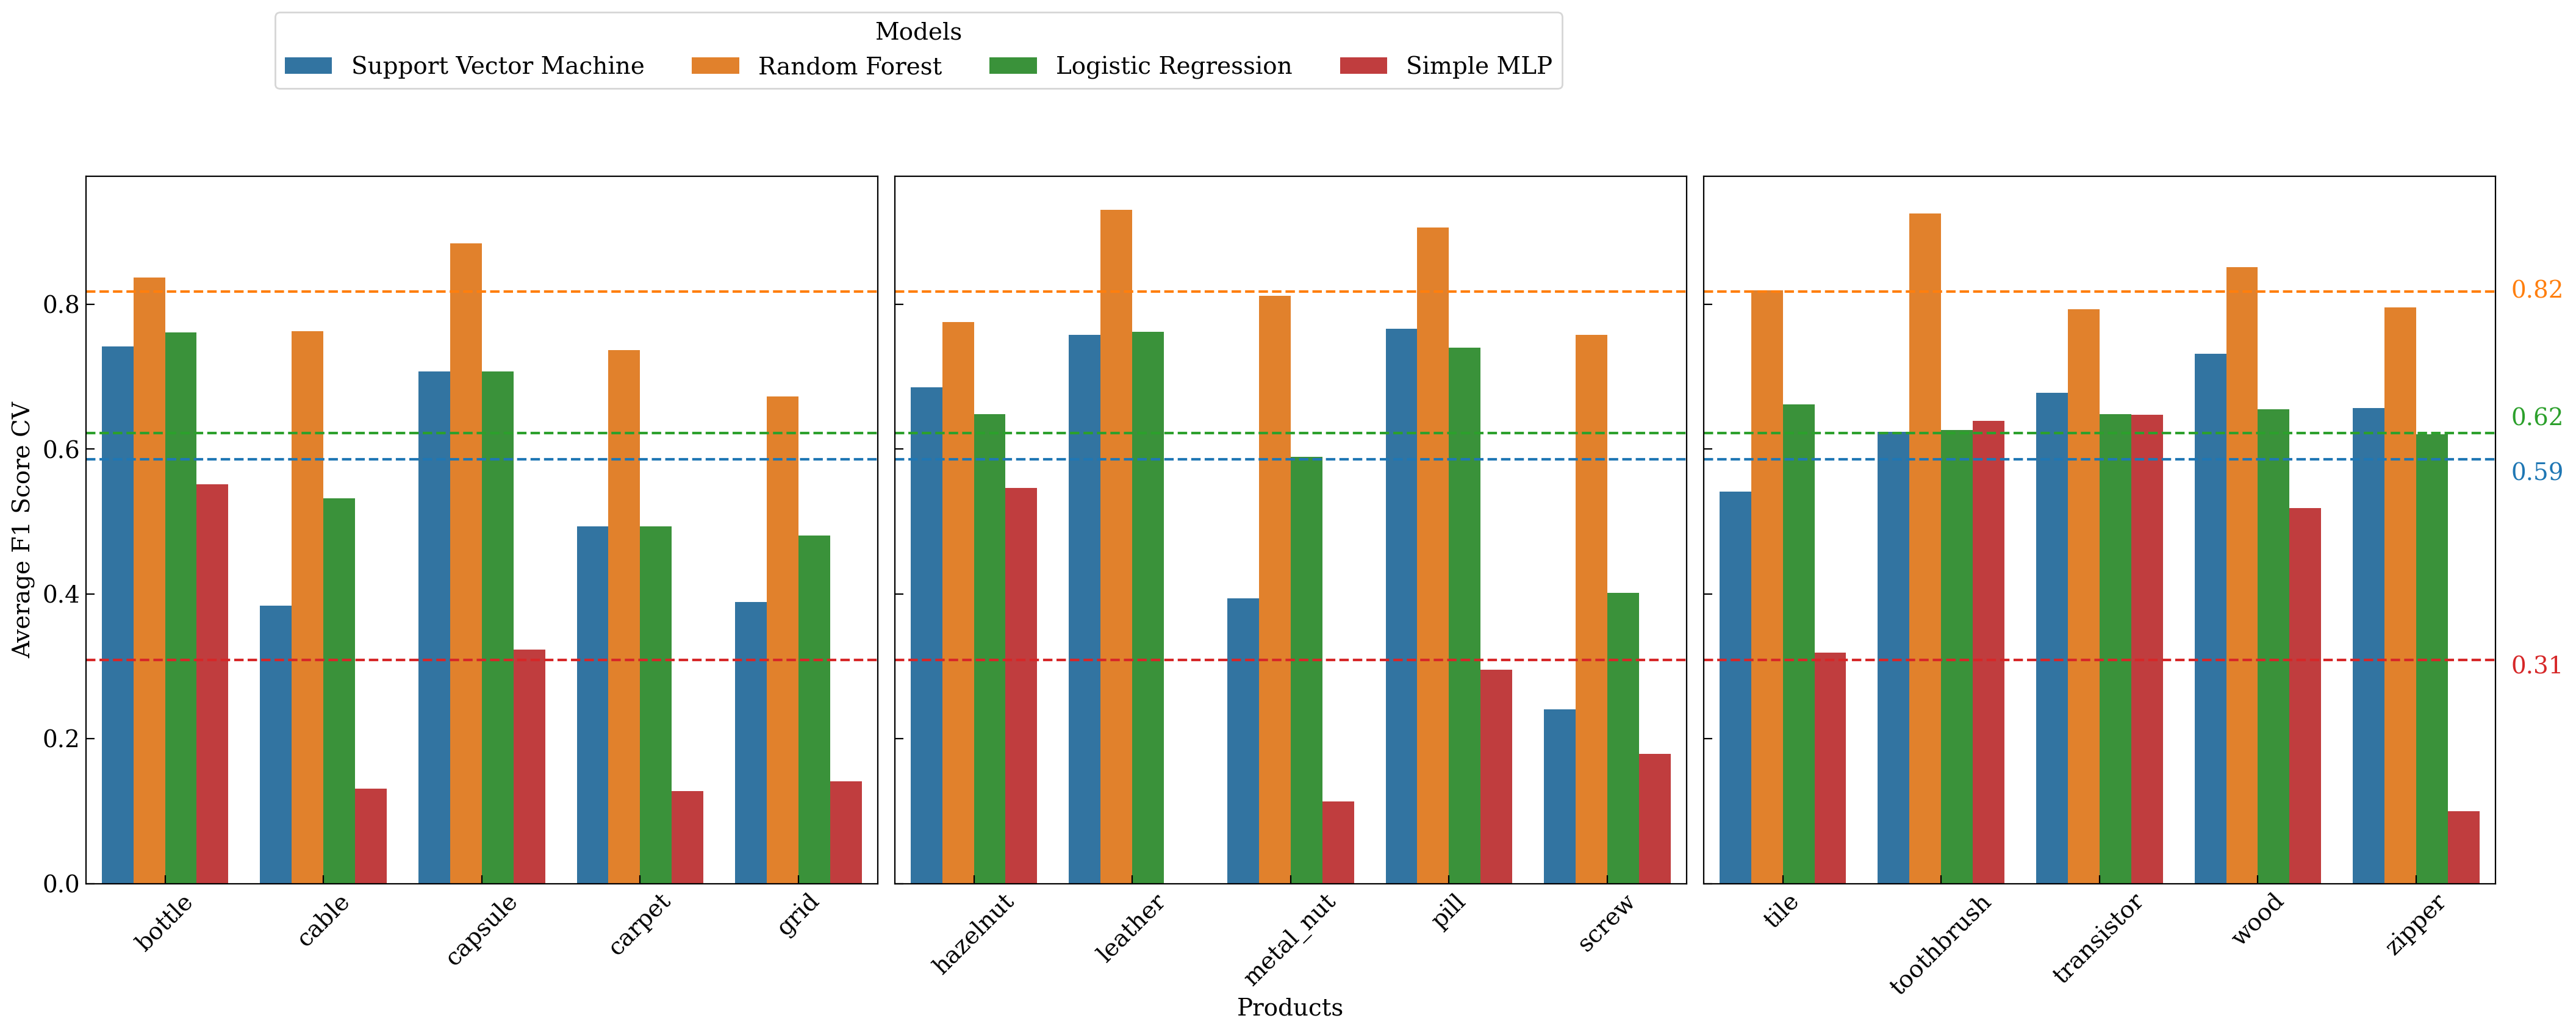

Model
Support Vector Machine    0.639458
Random Forest             0.883686
Logistic Regression       0.677383
Simple MLP                0.667617
Name: Value, dtype: float64


/tmp/ipykernel_39110/4031512491.py:149: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.85)


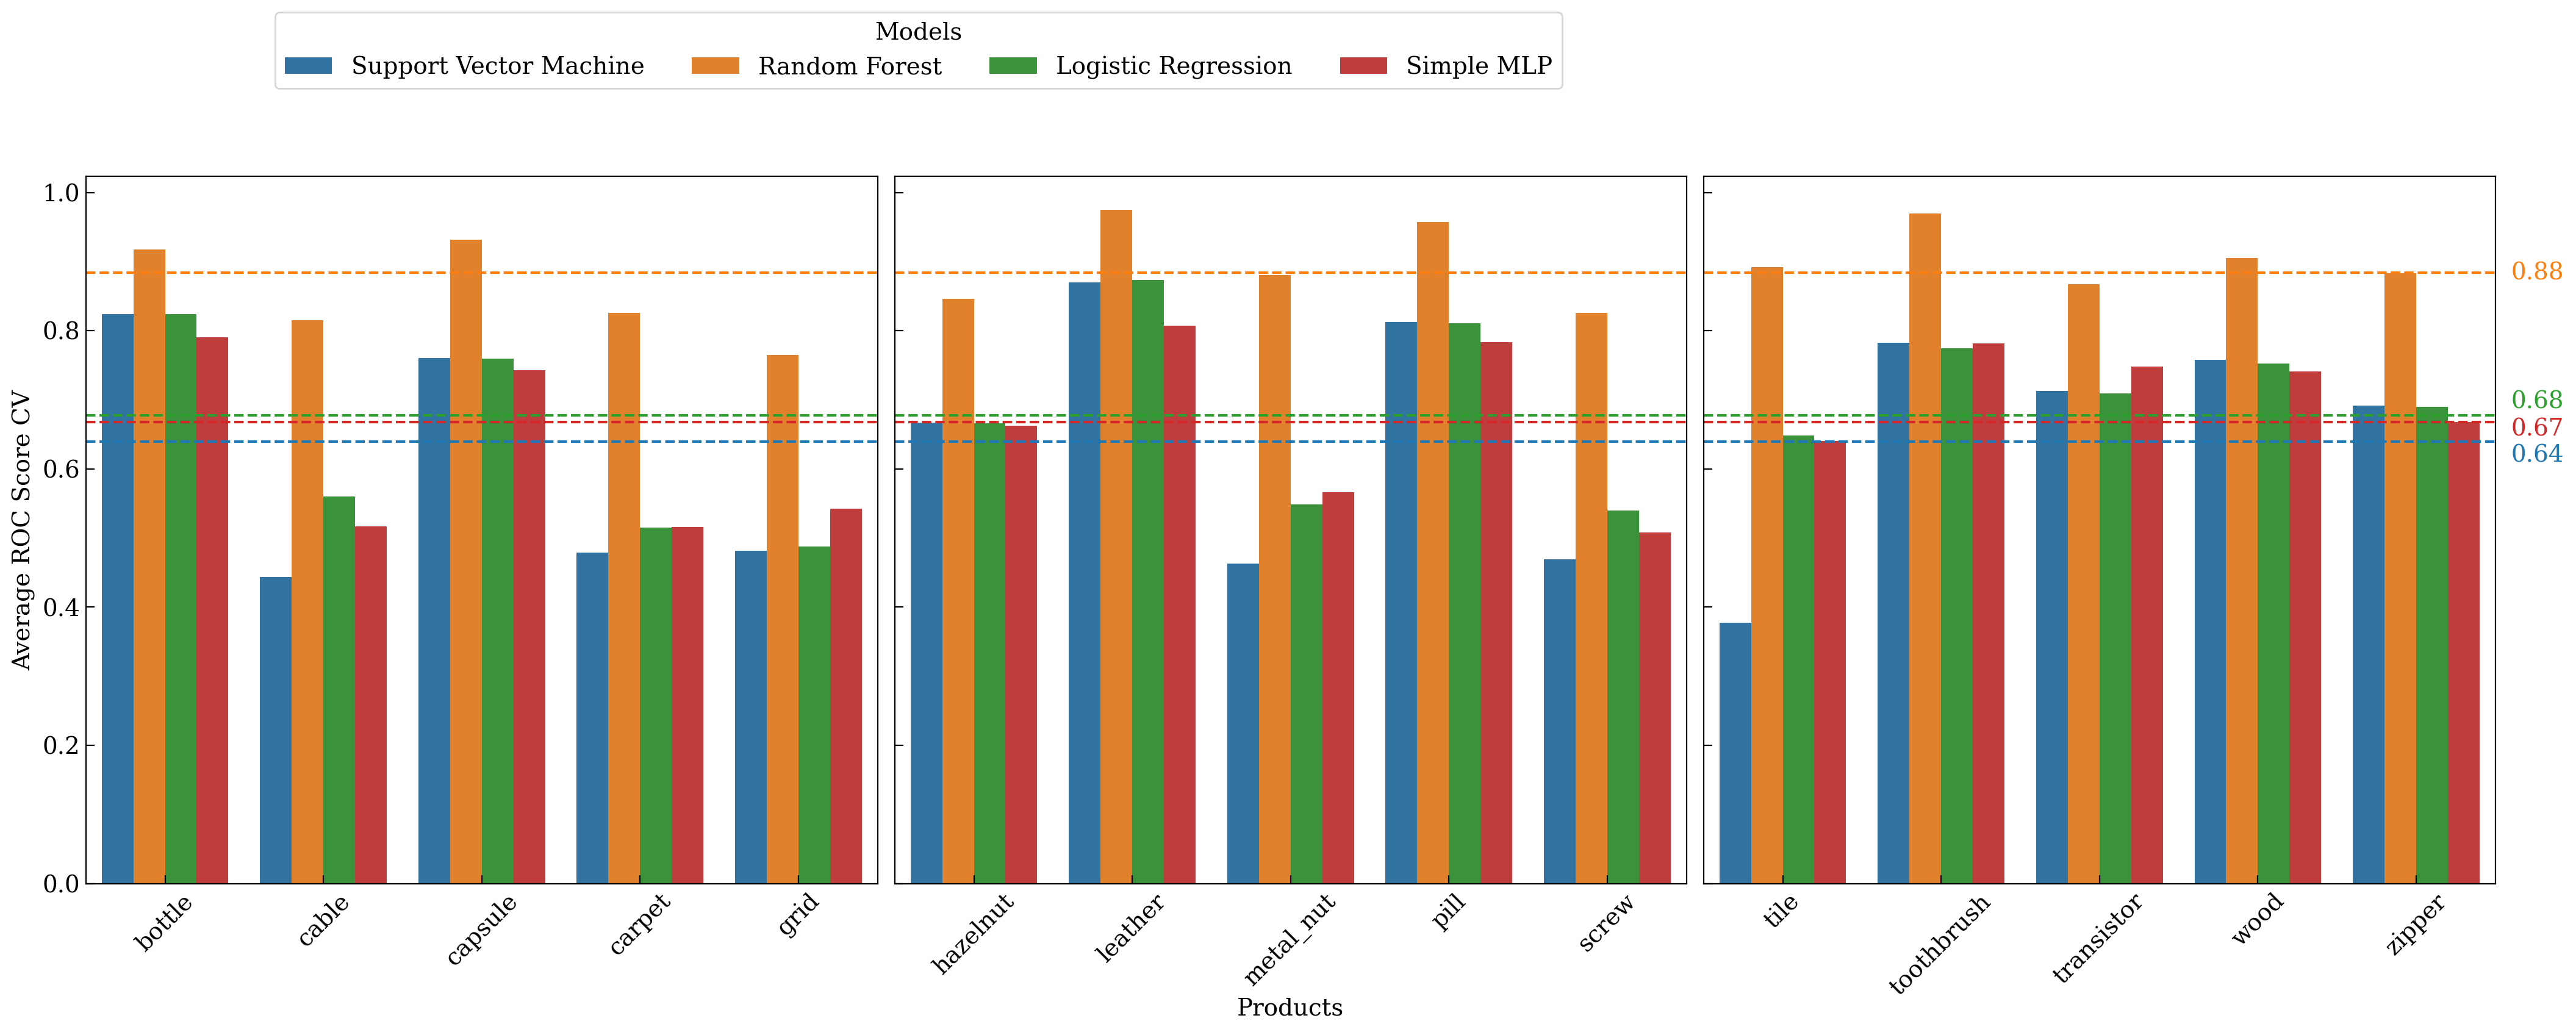

Model
Support Vector Machine    0.572672
Random Forest             1.000000
Logistic Regression       0.563528
Simple MLP                0.240287
Name: Value, dtype: float64


/tmp/ipykernel_39110/4031512491.py:149: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.85)


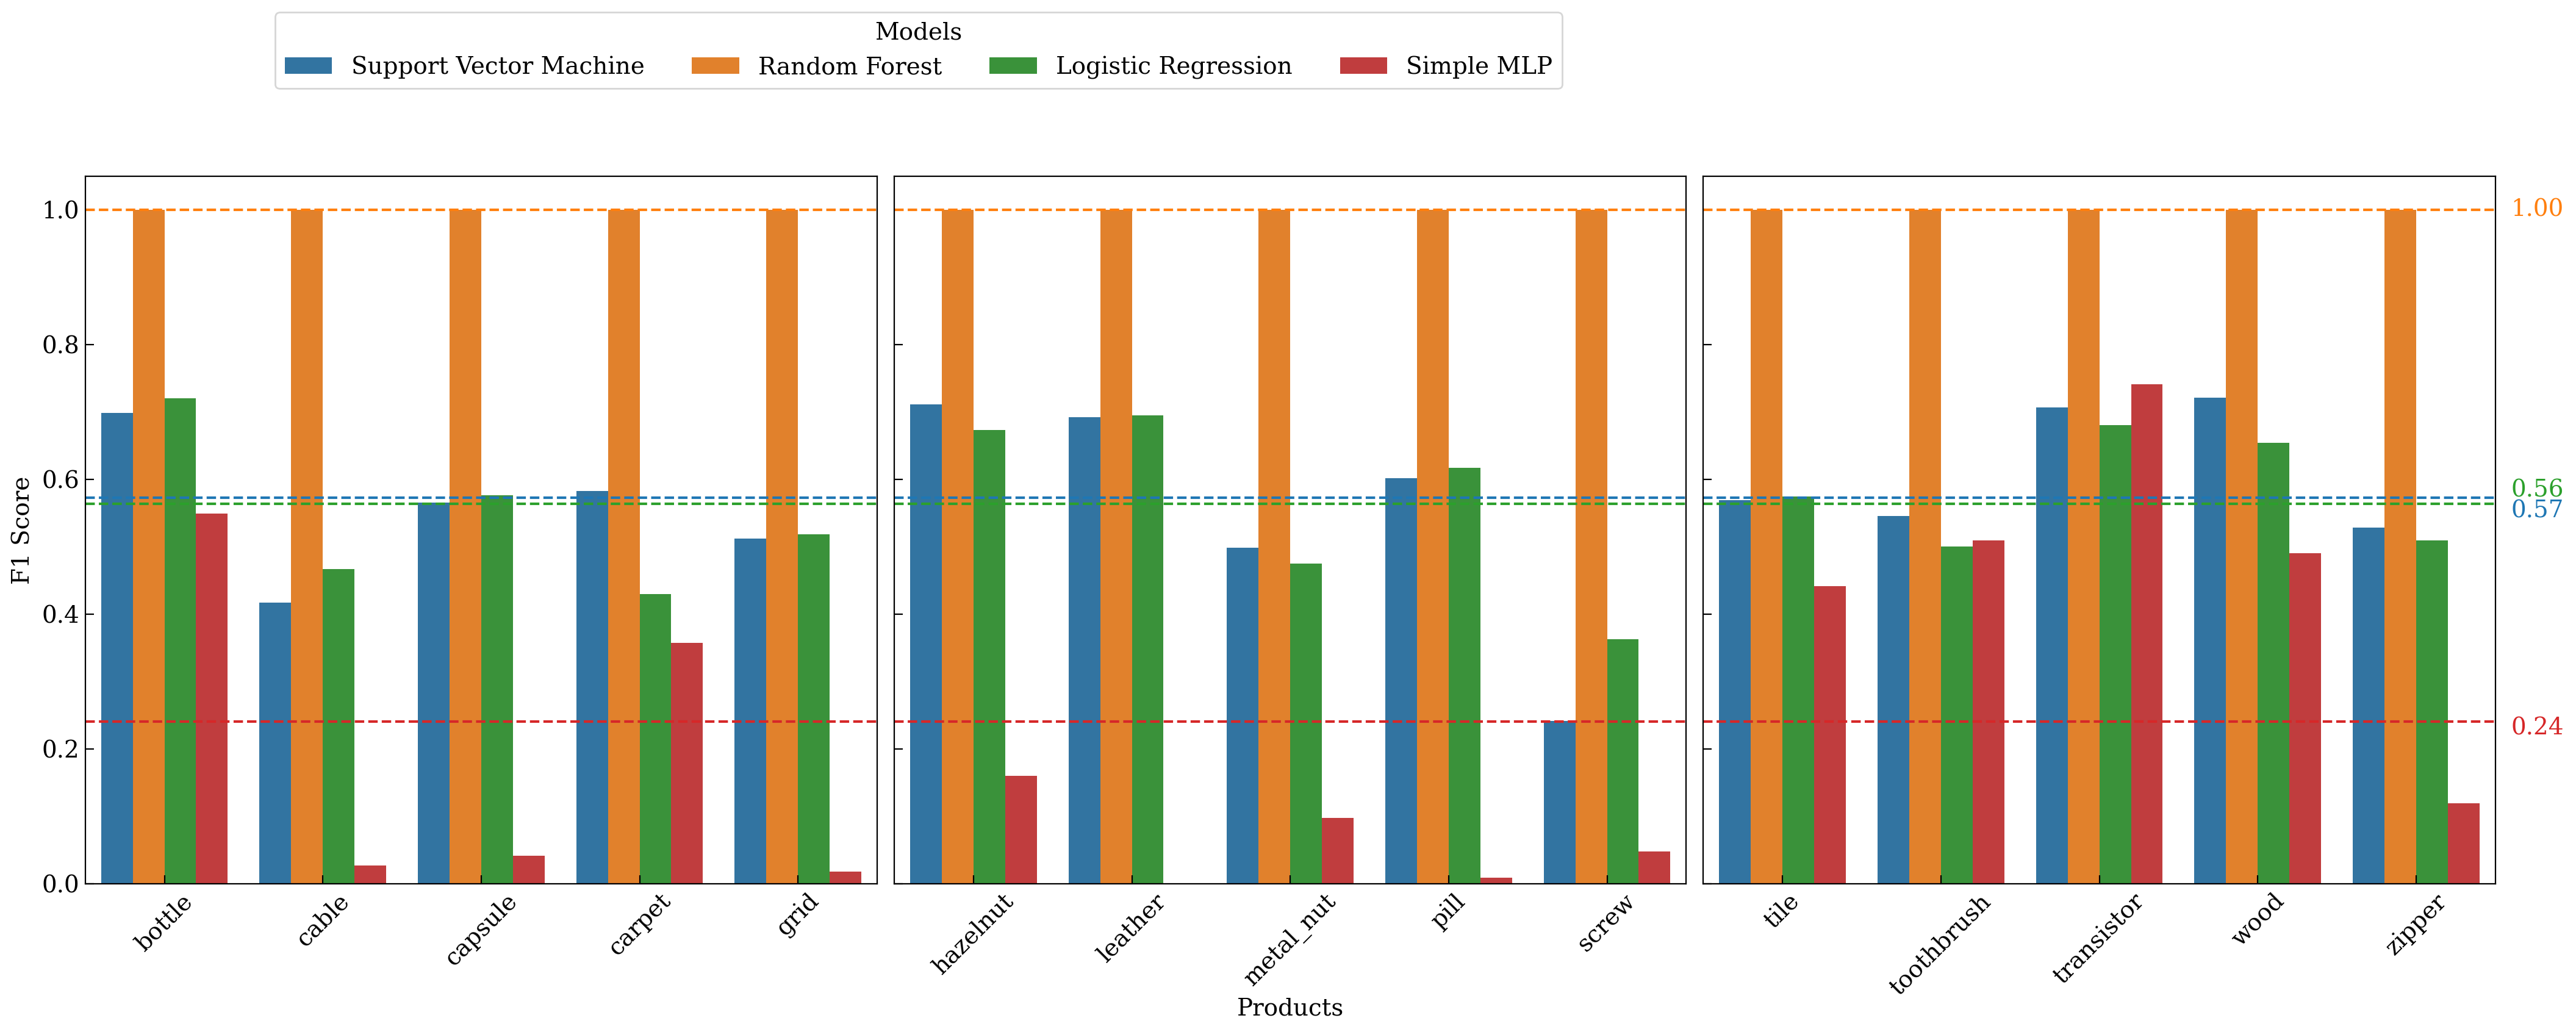

Model
Support Vector Machine    0.648238
Random Forest             1.000000
Logistic Regression       0.682148
Simple MLP                0.681179
Name: Value, dtype: float64


/tmp/ipykernel_39110/4031512491.py:149: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.85)


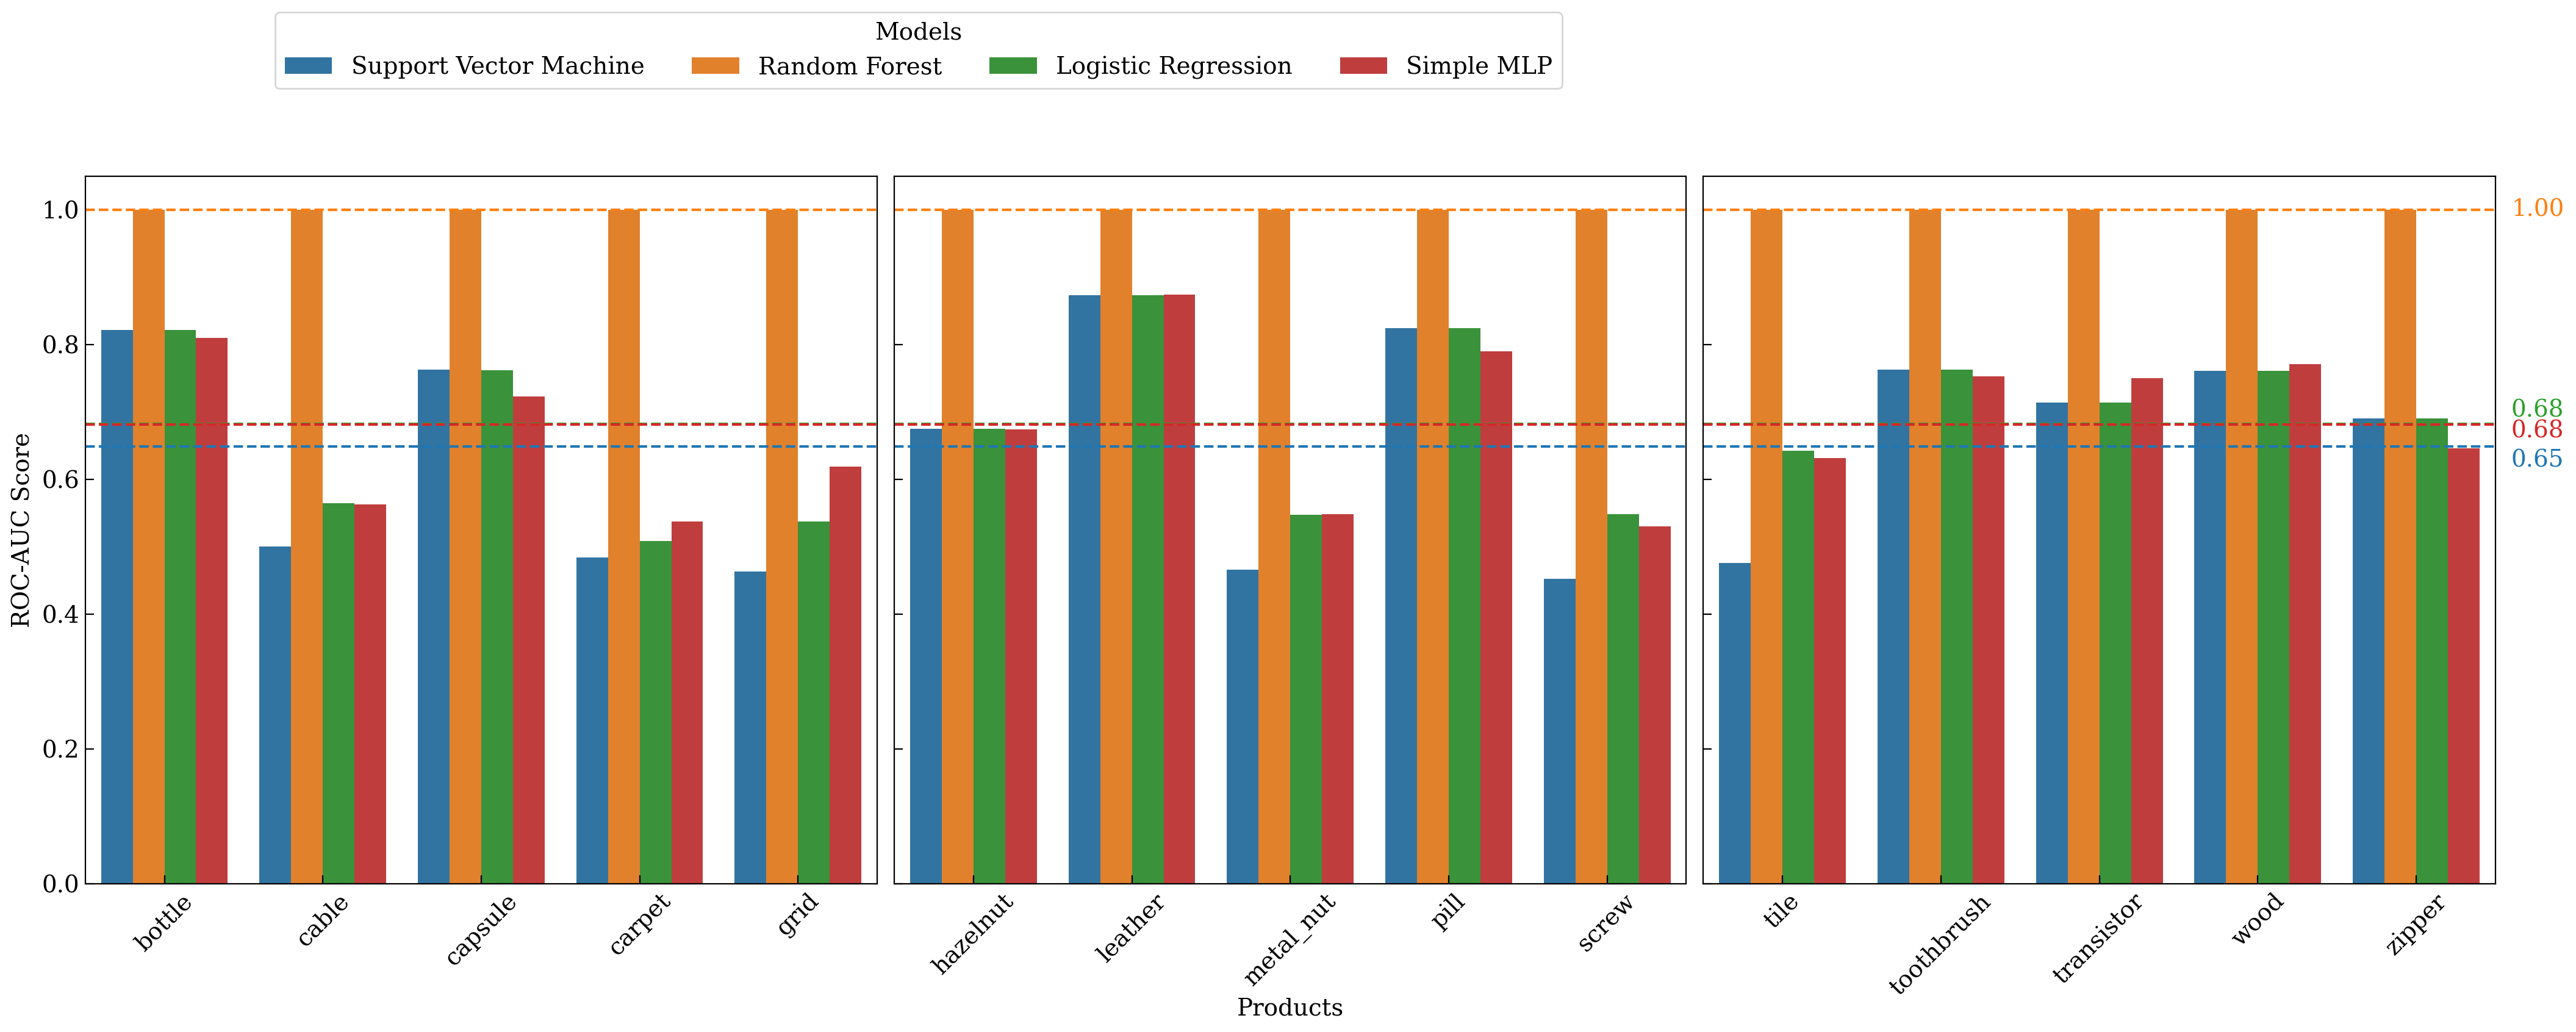

In [10]:
# Prepare data for DataFrame
avg_f1_data = []
avg_roc_data = []
f1_data = []
roc_data = []

# Mapping for better display names in the legend
model_display_names = {
    "svm": "Support Vector Machine",
    "rf": "Random Forest",
    # "ridge": "Ridge Regression",
    "xgb": "XGBoost",
    "logit": "Logistic Regression",
    "mlp": "Simple MLP",
}

for product, models in all_score_dict.items():
    for model, values in models.items():
        display_name = model_display_names[model]
        avg_f1_data.append(
            {
                "Product": product,
                "Model": display_name,
                "Value": values[0],
                "Type": "Average F1 Score CV",
            }
        )
        avg_roc_data.append(
            {
                "Product": product,
                "Model": display_name,
                "Value": values[1],
                "Type": "Average ROC Score CV",
            }
        )
        f1_data.append(
            {
                "Product": product,
                "Model": display_name,
                "Value": values[2],
                "Type": "F1-Score",
            }
        )
        roc_data.append(
            {
                "Product": product,
                "Model": display_name,
                "Value": values[3],
                "Type": "ROC-AUC Score",
            }
        )

# Convert to DataFrame
avg_f1_data = pd.DataFrame(avg_f1_data)
avg_roc_data = pd.DataFrame(avg_roc_data)
f1_data = pd.DataFrame(f1_data)
roc_data = pd.DataFrame(roc_data)

for i in range(4):
    title = ["Average F1 Score CV", "Average ROC Score CV",
             "F1 Score", "ROC-AUC Score"][i]
    data = [avg_f1_data, avg_roc_data, f1_data, roc_data][i]

    groups = [sorted(products)[i*5:(i*5)+5] for i in range(3)]

    # Find maximum values for each model
    average_values = data.groupby("Model")["Value"].mean()[
        model_display_names.values()]
    print(average_values)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(
        21, 7), sharey=True, layout="constrained")

    # Create a dictionary to hold the colors for each model

    for j, group in enumerate(groups):
        group_df = data[data["Product"].isin(group)]

        sns_barplot = sns.barplot(
            data=group_df, x="Product", y="Value", hue="Model", ax=axes[j]
        )
        if j == 0:
            axes[j].set_ylabel(title)
        else:
            axes[j].set_ylabel("")
        if j == 1:
            axes[j].set_xlabel("Products")
        else:
            axes[j].set_xlabel("")
        axes[j].tick_params(axis="x", rotation=45)

        # Add horizontal lines for maximum values
        for idx, model in enumerate(average_values.index):
            # if idx == 2:
            #     color = sns.color_palette()[3]
            # elif idx == 0:
            #     color = sns.color_palette()[2]
            # elif idx == 3:
            #     color = sns.color_palette()[0]
            # else:
            #     color = sns.color_palette()[idx]
            color = sns.color_palette()[idx]
            average_value = average_values[model]
            axes[j].axhline(y=average_value, color=color, linestyle="--")

    # Add the text annotations for maximum values on the right side of the third plot
    for idx, (model, average_value) in enumerate(average_values.items()):
        # if idx == 2:
        #     color = sns.color_palette()[3]
        # elif idx == 0:
        #     color = sns.color_palette()[2]
        # elif idx == 3:
        #     color = sns.color_palette()[0]
        # else:
        #     color = sns.color_palette()[idx]
        color = sns.color_palette()[idx]
        if idx == 0:
            y_pos = average_value - 0.02
        elif idx == 3:
            y_pos = average_value + 0.02
        elif idx == 4:
            y_pos = average_value - 0.01
        else:
            y_pos = average_value  # if idx != 2 else average_value + 0.02
        axes[2].text(
            len(groups[2]) - 0.4,
            y_pos,
            f"{average_value:.2f}",
            color=color,
            va="center",
        )

    # Adjust the legend to be outside and on the top left of the first plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.1, 1.2),
        ncol=5,
        title="Models",
    )

    # Remove legends from individual subplots
    for ax in axes:
        ax.legend().remove()

    plt.subplots_adjust(top=0.85)
    plt.savefig(
        os.path.join(all_figure_path, title + "_histogram.png"), bbox_inches="tight"
    )
    plt.show()

# # Plotting f1 scores histogram
# plt.figure(figsize=(12, 8), layout="constrained")
# sns.barplot(data=f1_data, x="Product", y="Value", hue="Model")
# # plt.title("F1 Score by Model")
# plt.ylabel("F1 Score")
# plt.xlabel("Products")
# plt.xticks(rotation=45)
# plt.legend()
# plt.savefig(os.path.join(all_figure_path, "f1_scores_histogram.png"))


# # Plotting rpc scores histogram
# plt.figure(figsize=(12, 8), layout="constrained")
# sns.barplot(data=roc_data, x="Product", y="Value", hue="Model")
# # plt.title("ROC-AUC Score by Model")
# plt.ylabel("ROC-AUC Score")
# plt.xlabel("Products")
# plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.005, 1))
# plt.savefig(os.path.join(all_figure_path, "roc_scores_histogram.png"))